In [1]:
from scipy.integrate import ode, solve_ivp
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bisect

sys.path.append('../')
from simulator_myokit import Simulator
sys.path.append('../../')
import plot_cell

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
sys.path.append('../Protocols')
from protocols import optimized_VC_Christini
'''
O'Hara-Rudy model with Christini-VC
'''
model_path = "../mmt-model-files/newordherg_qNet_VC_v100.mmt" 
sim_params = {
    'cell.mode': 1,            # 'Endocardial' : 0,    'Epicardial' : 1,    'Mid-myocardial' : 2,
    
    'ina.GNa' : 75,            # 75
    'inal.GNaL' : 0.0075*0.6,  # if(cell.mode == 1, GNaL_b*0.6, GNaL_b) GNaL_b=0.0075     
    'ito.Gto' : 0.02*4,        # piecewise(cell.mode == 1, Gto_b*4.0, cell.mode == 2, Gto_b*4.0, Gto_b) Gto_b = 0.02
    'ical.PCa' : 0.0001*1.2,   # piecewise(cell.mode == 0, base, cell.mode == 1, 1.2*base, 2.5*base) base = 0.0001
    'ikr.GKr' : 0.046*1.3,     # piecewise(cell.mode == 1, GKr_b*1.3, cell.mode == 2, GKr_b*0.8, GKr_b) GKr_b = 0.046    
    'iks.GKs' : 0.0034*1.4 ,   # if(cell.mode == 1, GKs_b * 1.4, GKs_b) GKs_b = 0.0034    
    'ik1.GK1' : 0.1908*1.2,    # piecewise(cell.mode == 1, GK1_b * 1.2, cell.mode == 2, GK1_b * 1.3, GK1_b) GK1_b = 0.1908
    'ifunny.Gf' : 0.0435           # 0.0435
} 

G_li = ['ina.GNa', 'inal.GNaL', 'ito.Gto', 'ical.PCa', 'ikr.GKr', 'iks.GKs', 'ik1.GK1', 'ifunny.Gf']
I_li = ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'ifunny.If']   

# G_li = ['ina.GNa', 'inal.GNaL', 'ito.Gto', 'ical.PCa', 'ikr.GKr', 'iks.GKs', 'ik1.GK1']
# I_li = ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1']   

start_time = time.time()
simulator = Simulator(model_path, optimized_VC_Christini, pre_sim=2) 
simulator.name = "O'Hara-Rudy model with Christini-VC_v100"
Gs = [simulator.model.get(G).value() for G in G_li]
times = np.arange(0, simulator.protocol_total_duration, 1)# np.linspace(0, simulator.total_duration, 20000)  
simulator.set_simulation_params(sim_params)
d = simulator.simulate(times, extra_log=I_li)        
print(Gs)
print("--- %s seconds ---"%(time.time()-start_time))

D:\Asan\Codes\Electrophysiology\Simulation_Myokit\Protocols\trial_steps_ramps_Kernik_200_50_4_-120_60/shortened_trial_steps_ramps_Kernik_200_50_4_-120_60_500_artefact_True_short.pkl
The protocol is 9055.950603217367 ms
[75.0, 0.0075, 0.02, 0.0001, 0.046, 0.0034, 0.1908, 0.0435]
--- 13.012766122817993 seconds ---


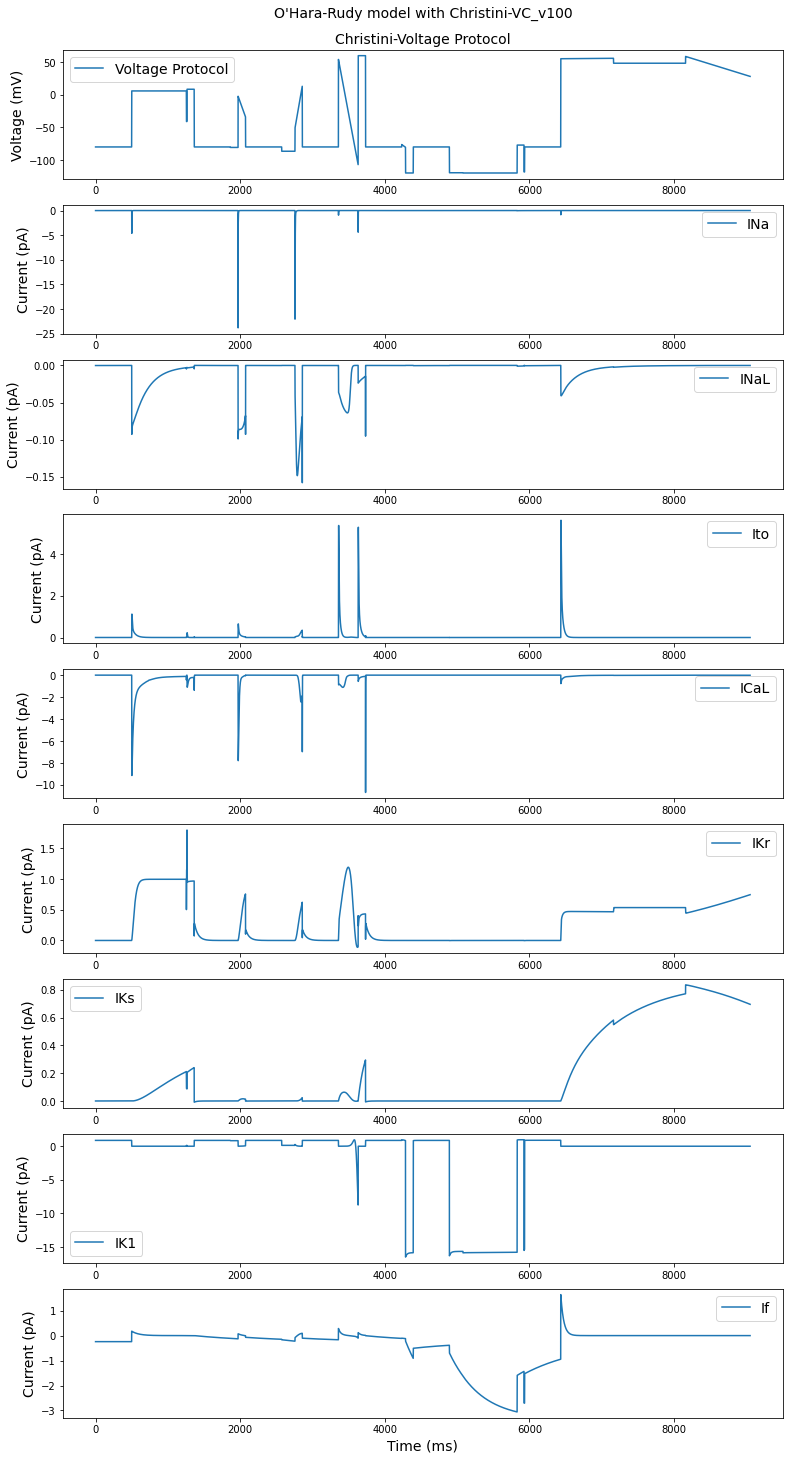

In [3]:
fig, axes = plt.subplots(9,1, figsize=(10, 20))
fig.suptitle(simulator.name, fontsize=14)
# plt.suptitle(simulator.name, fontsize=14)
axes[0].set_title("Christini-Voltage Protocol", fontsize=14)
# axs[0].set_xlim( , )
# axs[0].set_ylim( , )
# axs[0].set_xlabel("Time (ms)")
# axes[0].xaxis.set_visible(False)
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot(d['engine.time'], d['membrane.V'], label="Voltage Protocol")
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axs[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
# fig.savefig(save_path, dpi=100)

for i, I in enumerate(I_li):
    # axs[i+1].set_title(I.split('.')[1])
    # if i>0:
    #     axs[i+1].xaxis.set_visible(False)
    axes[i+1].set_ylabel("Current (pA)", fontsize=14)
    axes[i+1].plot(d['engine.time'], d[I], label=I.split('.')[1])
    axes[i+1].legend(fontsize=14) 
axes[8].set_xlabel("Time (ms)", fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.95, wspace=0.5, hspace=0.2)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()

In [4]:
"Complete"

'Complete'